In [1]:
import jax
import jax.numpy as np
import jraph
import flax.linen as nn
import numpy as onp
import matplotlib.pyplot as plt

from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

from models.gnn import GraphConvNet
from models.graph_utils import nearest_neighbors
from models.graph_utils import add_graphs_tuples

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-04-06 14:46:39.536288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/glib/2.56.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/12.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/12.1.0-fasrc01/lib:/n/helmod/apps/centos7/Core/cudnn/8.5.0.96_cuda11-fasrc01/lib:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/mpc/1.2.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/mpfr/4.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gmp/6.2.1-fasrc01/lib64
2023-04-06 14:46:39.536784: W tensorflow/compiler/xla/stream_executor/platform/defaul

In [4]:
n_nodes = 5000
x = np.load("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/halos.npy")[:, :n_nodes,:]

In [5]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x[:4], 20)

## EGNN

In [6]:
from models.egnn import EGNN

In [7]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(EGNN(
                        message_passing_steps=1,
                ))
        return model(x)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

## Test equivariance

In [8]:
from models.graph_utils import rotate_representation

In [9]:
graph = jraph.GraphsTuple(
          n_node=np.array(4 * [[n_nodes]]), 
          n_edge=np.array(4 * [[20]]),
          nodes=x[:4, :, :], 
          edges=None,
          globals=np.ones((4, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)

x_out = graph_out.nodes

angle_deg = 45.
axis = np.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)])

x_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x_out, angle_deg, axis)

graph = jraph.GraphsTuple(
          n_node=np.array(4 * [[n_nodes]]), 
          n_edge=np.array(4 * [[20]]),
          nodes=jax.vmap(rotate_representation, in_axes=(0,None,None))(x[:4, :, :], angle_deg, axis),
          edges=None,
          globals=np.ones((4, 7)),
          senders=sources,
          receivers=targets)

graph_out, params = model.init_with_output(rng, graph)
x_out = graph_out.nodes

(array([479., 482., 526., 472., 535., 527., 471., 533., 490., 485.]),
 array([-9.9980158e-01, -7.9986787e-01, -5.9993422e-01, -4.0000054e-01,
        -2.0006686e-01, -1.3318658e-04,  1.9980049e-01,  3.9973417e-01,
         5.9966785e-01,  7.9960155e-01,  9.9953520e-01], dtype=float32),
 <BarContainer object of 10 artists>)

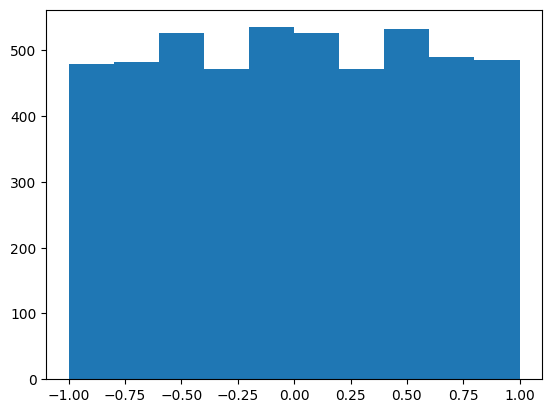

In [10]:
plt.hist(onp.array(x_out)[0,:,2])

In [11]:
# Equivariance ratio
eq_ratio = x_out / x_out_rot
print(eq_ratio.max(), eq_ratio.min(), eq_ratio)

1.003726 0.9985483 [[[1.         0.9999976  0.99999964 ... 0.9999976  0.99999964 1.        ]
  [1.         1.0000001  1.0000002  ... 1.0000001  1.0000002  1.        ]
  [1.0000001  1.0000001  0.99999994 ... 1.0000001  0.99999994 1.        ]
  ...
  [1.0000001  1.         1.0000001  ... 1.         1.0000001  1.        ]
  [1.0000001  0.99999994 1.         ... 0.99999994 1.         1.        ]
  [1.0000001  1.0000001  1.0000001  ... 1.0000001  1.0000001  1.        ]]

 [[0.99999994 0.9999998  1.         ... 0.9999998  1.         1.        ]
  [1.0000004  1.0000001  1.         ... 1.0000001  1.         1.        ]
  [0.99999994 1.0000001  0.9999998  ... 1.0000001  0.9999998  1.        ]
  ...
  [1.0000001  1.0000001  1.0000001  ... 1.0000001  1.0000001  1.        ]
  [1.0000002  1.0000001  0.9999999  ... 1.0000001  0.9999999  1.        ]
  [1.0000002  1.         1.         ... 1.         1.         1.        ]]

 [[1.0000001  1.0000001  1.0000001  ... 1.0000001  1.0000001  1.        ]
  [

In [489]:
sum(x.size for x in jax.tree_util.tree_leaves(params))

119316